In [1]:
%load_ext autoreload
%autoreload 2
import sys

import matplotlib.pyplot as plt
from astropy.table import Table
import numpy as np
sys.path.append('../target_selection/')
import lbg
from conversion import conv_COSMOS_XMM
sys.path.append('../')
import degrade_photometry


In [2]:
data_path = '/global/cfs/cdirs/desi/users/cpayerne/data_WP221_Target_selection/photometric_catalogs/'
catalog = Table.read(data_path + 'COSMOS_11bands-SExtractor-Lephare.fits')
mag_depth = [27,27,26.7,26.5,26] #ugriz

In [3]:
conv = conv_COSMOS_XMM

In [4]:
def refined_selection_u(tab, conv):
    
    mask  = tab[conv['u_err']] > 0
    mask *= tab[conv['g_err']] > 0
    mask *= tab[conv['r_err']] > 0

    #mask *= tab[conv['u_err']] < 1
    #mask *= tab[conv['g_err']] < 0.2
    mask *= tab[conv['r_err']] < 1

    mask *= abs(tab[conv['u']] - tab[conv['g']])  < 10
    mask *= abs(tab[conv['g']] - tab[conv['r']])  < 10
    #mask *= abs(tab[conv['u']] - tab[conv['r']])  < 10
    return mask

def refined_selection_g(tab, conv):
    
    mask = tab[conv['g_err']] > 0
    mask *= tab[conv['r_err']] > 0
    mask *= tab[conv['i_err']] > 0

   # mask *= tab[conv['g_err']] < 1
    #mask *= tab[conv['r_err']] < 1
    mask *= tab[conv['i_err']] < 1

    mask *= abs(tab[conv['g']] - tab[conv['r']])  < 10
    mask *= abs(tab[conv['r']] - tab[conv['i']])  < 10

    return mask

def refined_selection_r(tab, conv):

    mask = tab[conv['r_err']] > 0
    mask *= tab[conv['i_err']] > 0
    mask *= tab[conv['z_err']] > 0

   # mask *= tab[conv['r_err']] > 0
   # mask *= tab[conv['i_err']] < 1
    mask *= tab[conv['z_err']] < 1

    return mask

In [5]:
mask_udrop = lbg.LBG_SELECTION(catalog, conv, name='COSMOS_BXU_U_normagcut') * refined_selection_u(catalog, conv)
#mask_udrop *=  catalog['CLASS_STAR_HSC_I'] < 0.5
cat_lbg_udrop = catalog[mask_udrop]

In [6]:
bins=[np.linspace(0, 6, 30), np.linspace(22, 27, 30)]

In [15]:
count, z_edges, mag_edges = np.histogram2d(
    cat_lbg_udrop['ZPHOT'],
    cat_lbg_udrop['r'],
    bins=bins)
z_centers = 0.5 * (z_edges[:-1] + z_edges[1:])
mag_centers = 0.5 * (mag_edges[:-1] + mag_edges[1:])
count[z_centers < 2, :] = 0
print(count.shape)

(29, 29)


In [16]:
S = 1.67
np.savez(f'../target_selection/photom_redshift_distribution/cosmos_N_zm_udropout.npz',
     z_center=z_centers, 
     rmag_center=mag_centers,
     object_count=count,
     surface_deg2=S)

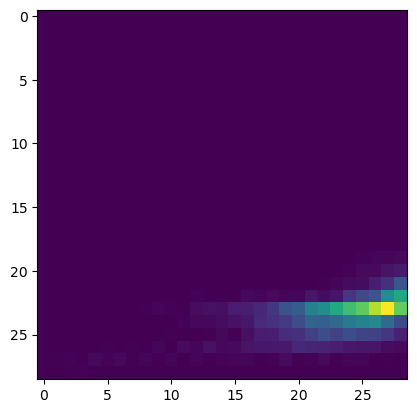

In [27]:
plt.imshow(count)

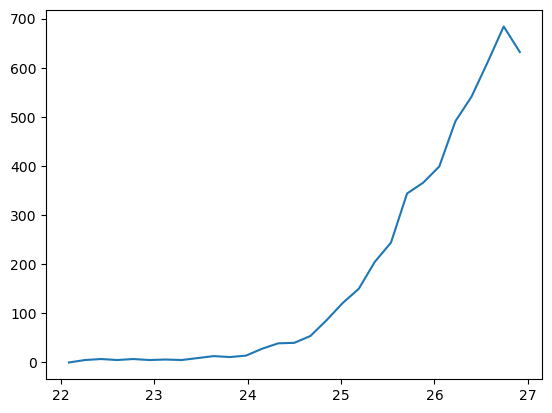

In [26]:
plt.plot(mag_centers, np.sum(count, axis=0))

In [17]:
mask_gdrop = lbg.LBG_SELECTION(catalog, conv, name='COSMOS_G_noimagcut') * refined_selection_g(catalog, conv)
#mask_gdrop *=  catalog['CLASS_STAR_HSC_I'] < 0.5
cat_lbg_gdrop = catalog[mask_gdrop]

In [18]:
count, z_edges, mag_edges = np.histogram2d(
    cat_lbg_gdrop['ZPHOT'],
    cat_lbg_gdrop['i'],
    bins=bins)
z_centers = 0.5 * (z_edges[:-1] + z_edges[1:])
mag_centers = 0.5 * (mag_edges[:-1] + mag_edges[1:])
count[z_centers < 3, :] = 0
print(count.shape)
np.savez(f'../target_selection/photom_redshift_distribution/cosmos_N_zm_gdropout.npz',
     z_center=z_centers, 
     imag_center=mag_centers,
     object_count=count,
     surface_deg2=S)

(29, 29)


In [19]:
mask_rdrop = lbg.LBG_SELECTION(catalog, conv, name='COSMOS_R_nozmagcut') * refined_selection_r(catalog, conv)
#mask_rdrop *=  catalog['CLASS_STAR_HSC_I'] < 0.5
cat_lbg_rdrop = catalog[mask_rdrop]

In [20]:
count, z_edges, mag_edges = np.histogram2d(
    cat_lbg_rdrop['ZPHOT'],
    cat_lbg_rdrop['z'],
    bins=bins)
z_centers = 0.5 * (z_edges[:-1] + z_edges[1:])
mag_centers = 0.5 * (mag_edges[:-1] + mag_edges[1:])
count[z_centers < 4, :] = 0
print(count.shape)
np.savez(f'../target_selection/photom_redshift_distribution/cosmos_N_zm_rdropout.npz',
     z_center=z_centers, 
     zmag_center=mag_centers,
     object_count=count,
     surface_deg2=S)

(29, 29)


In [21]:
N_zm_u = np.load(f'../target_selection/photom_redshift_distribution/cosmos_N_zm_udropout.npz')
N_zm_g = np.load(f'../target_selection/photom_redshift_distribution/cosmos_N_zm_gdropout.npz')
N_zm_r = np.load(f'../target_selection/photom_redshift_distribution/cosmos_N_zm_rdropout.npz')

Text(0.5, 0, 'm-detect < m')

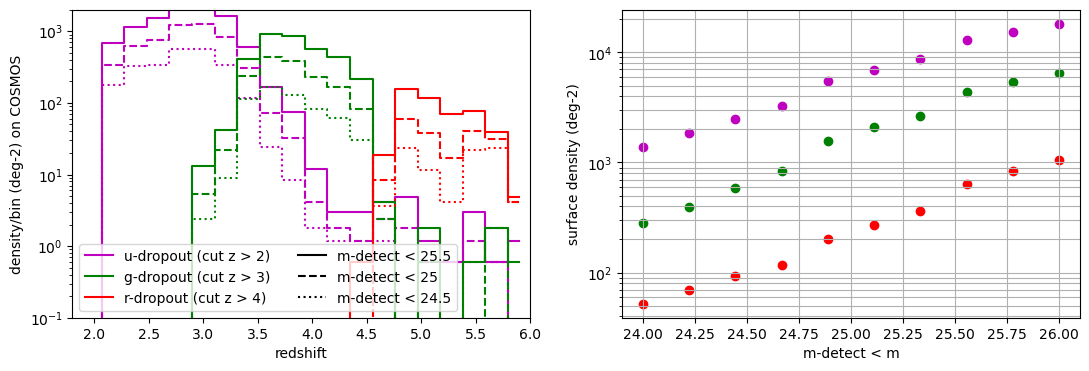

In [22]:
plt.figure(figsize=(13,4))
plt.subplot(121)
N_zm_u = np.load(f'../target_selection/photom_redshift_distribution/cosmos_N_zm_udropout.npz')
plt.step(N_zm_u['z_center'], np.sum(N_zm_u['object_count'][:,N_zm_u['rmag_center'] < 25.5], axis=1)/S, where='mid', color = 'm')
plt.step(N_zm_u['z_center'], np.sum(N_zm_u['object_count'][:,N_zm_u['rmag_center'] < 25], axis=1)/S, '--',where='mid', color = 'm')
plt.step(N_zm_u['z_center'], np.sum(N_zm_u['object_count'][:,N_zm_u['rmag_center'] < 24.5], axis=1)/S, ':',where='mid', color = 'm')

N_zm_g = np.load(f'../target_selection/photom_redshift_distribution/cosmos_N_zm_gdropout.npz')
plt.step(N_zm_g['z_center'], np.sum(N_zm_g['object_count'][:,N_zm_g['imag_center'] < 25.5], axis=1)/S, '-',where='mid', color = 'g')
plt.step(N_zm_g['z_center'], np.sum(N_zm_g['object_count'][:,N_zm_g['imag_center'] < 25], axis=1)/S,'--', where='mid',color = 'g')
plt.step(N_zm_g['z_center'], np.sum(N_zm_g['object_count'][:,N_zm_g['imag_center'] < 24.5], axis=1)/S, ':',where='mid',color = 'g')

N_zm_r = np.load(f'../target_selection/photom_redshift_distribution/cosmos_N_zm_rdropout.npz')
plt.step(N_zm_r['z_center'], np.sum(N_zm_r['object_count'][:,N_zm_r['zmag_center'] < 25.5], axis=1)/S,'-', where='mid',color = 'r')
plt.step(N_zm_r['z_center'], np.sum(N_zm_r['object_count'][:,N_zm_r['zmag_center'] < 25], axis=1)/S, '--',where='mid',color = 'r')
plt.step(N_zm_r['z_center'], np.sum(N_zm_r['object_count'][:,N_zm_r['zmag_center'] < 24.5], axis=1)/S,':',where='mid', color = 'r')

plt.plot([], [], 'm', label = 'u-dropout (cut z > 2)')

plt.plot([], [], 'g', label = 'g-dropout (cut z > 3)')

plt.plot([], [], 'r', label = 'r-dropout (cut z > 4)')

plt.plot([], [], '-k', label = 'm-detect < 25.5')

plt.plot([], [], '--k', label = 'm-detect < 25')

plt.plot([], [], ':k', label = 'm-detect < 24.5')
plt.ylim(0.1, 2000)
plt.yscale('log')
plt.xlabel('redshift')
plt.ylabel('density/bin (deg-2) on COSMOS')
plt.legend(ncols=2)
plt.xlim(1.8, 6)

plt.subplot(122)
for rmag in np.linspace(24, 26, 10):
    Ntot = np.sum(np.sum(N_zm_u['object_count'][:,N_zm_u['rmag_center'] < rmag], axis=1))
    plt.scatter(rmag, Ntot/S, c='m')
for rmag in np.linspace(24, 26, 10):
    Ntot = np.sum(np.sum(N_zm_g['object_count'][:,N_zm_g['imag_center'] < rmag], axis=1))
    plt.scatter(rmag, Ntot/S, c='g')
for rmag in np.linspace(24, 26, 10):
    Ntot = np.sum(np.sum(N_zm_r['object_count'][:,N_zm_r['zmag_center'] < rmag], axis=1))
    plt.scatter(rmag, Ntot/S, c='r')
plt.yscale('log')

plt.plot([], [], 'm', label = 'u-dropout')
plt.plot([], [], 'g', label = 'g-dropout')
plt.plot([], [], 'r', label = 'r-dropout')
plt.grid(which='both')
plt.ylabel('surface density (deg-2)')
plt.xlabel('m-detect < m')

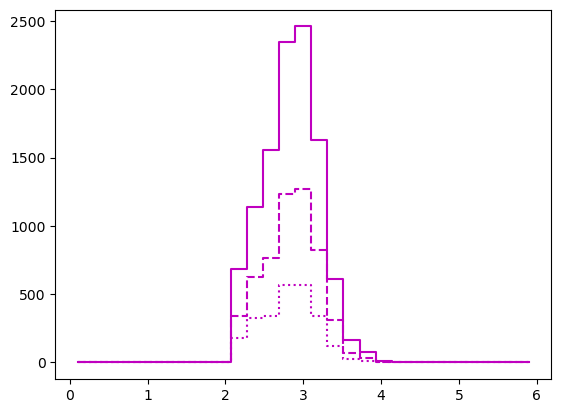

In [28]:
N_zm_u = np.load(f'../target_selection/photom_redshift_distribution/cosmos_N_zm_udropout.npz')
plt.step(N_zm_u['z_center'], np.sum(N_zm_u['object_count'][:,N_zm_u['rmag_center'] < 25.5], axis=1)/S, where='mid', color = 'm')
plt.step(N_zm_u['z_center'], np.sum(N_zm_u['object_count'][:,N_zm_u['rmag_center'] < 25], axis=1)/S, '--',where='mid', color = 'm')
plt.step(N_zm_u['z_center'], np.sum(N_zm_u['object_count'][:,N_zm_u['rmag_center'] < 24.5], axis=1)/S, ':',where='mid', color = 'm')


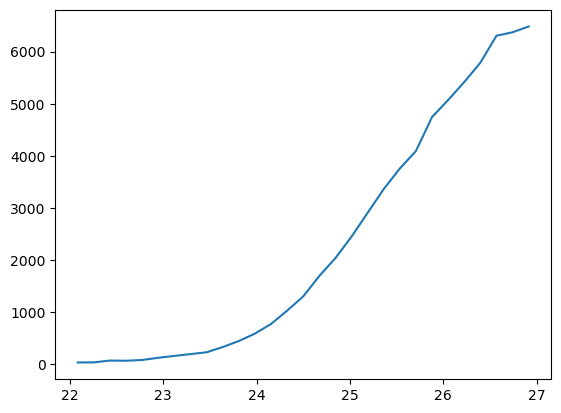

In [32]:
plt.plot(N_zm_u['rmag_center'], np.sum(N_zm_u['object_count'], axis=0))